In [9]:
import numpy as np
from numpy import array
from numpy.linalg import eigvals
from Quantum_Gate_np import*
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
# copied from openfermion output
Hamiltonian = [ (-0.09886396933545755+0j) * reduce(kron, (Id2, Id2, Id2, Id2)),
                (-0.045322202052874024+0j) * reduce(kron, (X, X, Y, Y)),
                (0.045322202052874024+0j) * reduce(kron, (X, Y, Y, X)),
                (0.045322202052874024+0j) * reduce(kron, (Y, X, X, Y)),
                (-0.045322202052874024+0j) * reduce(kron, (Y, Y, X, X)),
                (0.1711977490343294+0j) * reduce(kron, (Z, Id2, Id2, Id2)),
                (0.1686221915892096+0j) * reduce(kron, (Z, Z, Id2, Id2)),
                (0.12054482205301814+0j) * reduce(kron, (Z, Id2, Z, Id2)),
                (0.16586702410589216+0j) * reduce(kron, (Z, Id2, Id2, Z)),
                (0.1711977490343294+0j) * reduce(kron, (Id2, Z, Id2, Id2)),
                (0.16586702410589216+0j) * reduce(kron, (Id2, Z, Z, Id2)),
                (0.12054482205301814+0j) * reduce(kron, (Id2, Z, Id2, Z)),
                (-0.22278593040418518+0j) * reduce(kron, (Id2, Id2, Z, Id2)),
                (0.17434844185575699+0j) * reduce(kron, (Id2, Id2, Z, Z)),
                (-0.2227859304041852+0j) * reduce(kron, (Id2, Id2, Id2, Z))]

Hamiltonian = reduce(lambda m1, m2: m1 + m2, Hamiltonian)


# Ansatz circuit
def constructUfromTheta(n_qubit, depth, theta_list):
    gate_list = []

    for d in range(depth):
        for i in range(n_qubit):
            gate_matrix = RZ(theta = theta_list[2 * i + 1 + 2 * n_qubit * d]) @ RY(theta = theta_list[2 * i + 2 * n_qubit * d])
            gate = QuantumGate(n = n_qubit, free_bits_dict={i: gate_matrix}, target_bits_dict={}, controlled_bits_dict={})
            gate_list.append(gate)

        for i in range(n_qubit//2):
            gate = QuantumGate(n = n_qubit, free_bits_dict={}, target_bits_dict={2*i+1: X}, controlled_bits_dict={2*i: 1})
            gate_list.append(gate)

        for i in range(n_qubit//2 - 1):
            gate = QuantumGate(n = n_qubit, free_bits_dict={}, target_bits_dict={2*i+2: X}, controlled_bits_dict={2*i+1: 1})
            gate_list.append(gate)

    for i in range(n_qubit):
        gate_matrix = RZ(theta = theta_list[2 * i + 1 + 2 * n_qubit * depth]) @ RY(theta = theta_list[2 * i + 2 * n_qubit * depth])
        gate_list.append(gate)
    
    circuit = reduce(lambda m1, m2: m1 @ m2, map(lambda m1: m1.matrix_rep, reversed(gate_list)))

    return circuit


def H_Exp(Hamiltonian: array, n_qubit: int, depth: int, theta_list: array, in_state: array):
    

    circuit = constructUfromTheta(n_qubit = n_qubit, depth = depth, theta_list=theta_list)
    
    out_state = circuit @ in_state
    
    H_exptation = out_state.conjugate().T @ Hamiltonian @ out_state

    return H_exptation[0, 0].real




In [3]:
depth = 4
n_qubit = 4

theta_list = np.random.random(2 * n_qubit * (depth + 1)) * 1e-1

in_state_0 = generate_basis(4)[0].matrix_rep


def cost(theta_list):
    
    global N_call
    
    res = H_Exp(Hamiltonian=Hamiltonian, n_qubit = n_qubit, depth = depth, theta_list=theta_list, in_state=in_state_0)
    
    if N_call % 100 == 0:
        print(f'N_call: {N_call}, cost: {res:.6f}')


    N_call += 1

    return res


In [4]:
cost_history = []
options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
N_call = 0
res = minimize(fun = cost, x0 = theta_list, method = "BFGS", callback = lambda x: cost_history.append(cost(x)), options=options)

N_call: 0, cost: 0.699565
N_call: 100, cost: 0.520413
N_call: 200, cost: -0.110760
N_call: 300, cost: -0.428124
N_call: 400, cost: -0.374167
N_call: 500, cost: -0.656388
N_call: 600, cost: -1.038375
N_call: 700, cost: -1.104093
N_call: 800, cost: -1.112614
N_call: 900, cost: -1.115925
N_call: 1000, cost: -1.116324
N_call: 1100, cost: -1.116493
N_call: 1200, cost: -1.116611
N_call: 1300, cost: -1.116683
N_call: 1400, cost: -1.116707
N_call: 1500, cost: -1.116719
N_call: 1600, cost: -1.116722
N_call: 1700, cost: -1.116725
N_call: 1800, cost: -1.116739
N_call: 1900, cost: -1.116767
N_call: 2000, cost: -1.116794
N_call: 2100, cost: -1.116948
N_call: 2200, cost: -1.117314
N_call: 2300, cost: -1.117907
N_call: 2400, cost: -1.118499
N_call: 2500, cost: -1.120378
N_call: 2600, cost: -1.122055
N_call: 2700, cost: -1.123242
N_call: 2800, cost: -1.126536
N_call: 2900, cost: -1.130799
N_call: 3000, cost: -1.131167
N_call: 3100, cost: -1.132896
N_call: 3200, cost: -1.133837
N_call: 3300, cost: -1.1

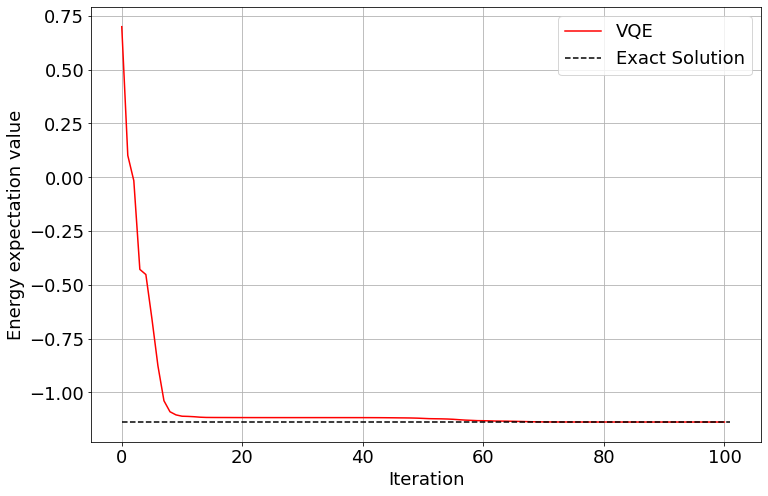

In [25]:
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = (12, 8)

E_initial = H_Exp(Hamiltonian=Hamiltonian, n_qubit=n_qubit, depth=depth, theta_list=theta_list, in_state=in_state_0)
plt.plot([E_initial.real] + cost_history, color="red", label="VQE")

min_eig = sorted(eigvals(Hamiltonian))[0].real
plt.plot(range(len(cost_history) + 2), [min_eig]*(len(cost_history)+2), linestyle="dashed", color="black", label="Exact Solution")

plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.grid()
plt.show()